<a id="top"></a>

# <div style="text-align:center; padding:15px; color:white; font-size:150%; font-family:'Trebuchet MS'; background:linear-gradient(90deg, #0f2027, #203a43, #2c5364); border-radius:12px;">🧠 Amazon Reviews Sentiment Analysis</div>


## 📌 Table of Contents

- [1. Imports and Configuration](#1)
- [2. Data Loading and Cleaning](#2)
- [3. Sentiment Analysis with BERT](#3)
- [4. Sentiment vs Star Rating Alignment](#4)
- [5. Results and Visualizations](#5)
- [6. Notable Examples](#6)
- [7. Export and Wrap-up](#7)


<a id="1"></a>

## 🔧 **Imports and Configuration**

In this section, we import all the necessary libraries for data manipulation, visualization, NLP, and transformer-based sentiment analysis. We also configure display settings, progress bars, and hardware utilization (CPU/GPU).


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm
import time
import torch
from torch.nn.functional import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download NLTK data
nltk.download('punkt', quiet=True)

# Register tqdm with pandas
tqdm.pandas(desc="Processing...")

# Display settings
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', 300)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Start timing
print("--- Script Start ---")
start_time = time.time()


Using device: cpu
--- Script Start ---


<a id="2"></a>

## 🗂️ **Data Loading and Cleaning**

We load the Amazon review dataset and clean it by:
- Handling missing values in text and score columns,
- Filtering out empty reviews,
- Ensuring all data is in the correct format for analysis.


In [2]:
# File path
file_path = 'Amazon Customer Reviews.csv'

# Load data
try:
    df = pd.read_csv(file_path, index_col='Id', usecols=['Id', 'Score', 'Text'])
    print(f"Loaded {file_path} successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    raise
except ValueError as e:
    print(f"ValueError: {e}. Attempting to read all columns...")
    df = pd.read_csv(file_path, index_col='Id')
    if not all(col in df.columns for col in ['Score', 'Text']):
        raise ValueError("Required columns 'Score' or 'Text' missing.")

print("Original DataFrame shape:", df.shape)

# Handle missing or malformed data
initial_rows = len(df)
df['Text'] = df['Text'].fillna('')
df['Score'] = (
    pd.to_numeric(df['Score'], errors='coerce')
      .fillna(0)
      .astype(int)
)

# Remove rows with empty text
df = df[df['Text'].str.strip() != '']
rows_after = len(df)
print(f"Removed {initial_rows - rows_after} rows; Current shape: {df.shape}")


Loaded Amazon Customer Reviews.csv successfully.
Original DataFrame shape: (568454, 2)
Removed 0 rows; Current shape: (568454, 2)


<a id="3"></a>

## 🤖 **Sentiment Analysis with BERT**

We use **`nlptown/bert-base-multilingual-uncased-sentiment`**, a multilingual pre-trained BERT model, to assess the sentiment of each review. This includes:
- Tokenization and model inference,
- Conversion of logits to sentiment scores (negative, neutral, positive),
- Calculation of a compound sentiment score for simplified comparison.

In [5]:
# Load model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

print("BERT model and tokenizer loaded.")

BERT model and tokenizer loaded.


### 🧠 **BERT Sentiment Function**

Defines `get_bert_sentiment()`, a robust helper function to:
- Tokenize and truncate long input text,
- Perform sentiment classification using BERT,
- Map logits to probabilities across 5 sentiment classes,
- Aggregate them into three main sentiment categories (`neg`, `neu`, `pos`) and a `compound` score.


In [7]:
# Helper function to analyze text
def get_bert_sentiment(text, max_length=512):
    try:
        if not isinstance(text, str) or text.strip() == '':
            return {'neg': 0.0, 'neu': 0.5, 'pos': 0.0, 'compound': 0.0}
        
        # Truncate long text
        if len(text) > max_length * 4:
            text = text[:max_length * 4]
        
        # Tokenize
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            scores = softmax(outputs.logits, dim=1).squeeze().tolist()

        # Convert scores
        if isinstance(scores, list):
            neg = sum(scores[0:2])
            neu = scores[2]
            pos = sum(scores[3:5])
            compound = (pos - neg) * 0.5
        else:
            neg, neu, pos, compound = 0.0, 1.0, 0.0, 0.0

        return {'neg': neg, 'neu': neu, 'pos': pos, 'compound': compound}
    
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

### 📊 **Sentiment Score Application**

- Applies the sentiment function to all text reviews using a progress bar.
- Flattens the resulting dictionaries into separate columns for easier analysis.


In [9]:
# Apply function with progress bar
print("Calculating BERT sentiment scores...")
bert_scores = df['Text'].progress_apply(get_bert_sentiment)

# Expand dicts to columns
bert_df = pd.json_normalize(bert_scores)
bert_df.index = df.index
df = pd.concat([df, bert_df], axis=1)

# Preview
print(df[['Score', 'Text', 'neg', 'neu', 'pos', 'compound']].head())

Calculating BERT sentiment scores...


Processing...: 100%|████████████████████████████████████████████████████████| 568454/568454 [25:53:04<00:00,  6.10it/s]


    Score  \
Id          
1       5   
2       1   
3       4   
4       2   
5       5   

                                                                                                                                                                                                                                                                                                           Text  \
Id                                                                                                                                                                                                                                                                                                                
1                                       I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better th

### 🎯 **Alignment Analysis**

- Compares user star scores to BERT-generated sentiment scores.
- Classifies alignment into:
  - Agreement (Pos-Pos / Neg-Neg)
  - Disagreement (PosScore-NegText / NegScore-PosText)
  - Ambiguous/Neutral
- Stores results in a new column `Alignment_BERT`.


In [10]:
# Define thresholds
bert_pos = 0.05
bert_neg = -0.05

# Alignment checking function
def check_alignment(row):
    score = row['Score']
    comp = row['compound']

    # Text sentiment
    if comp >= bert_pos:
        txt_cat = "Positive"
    elif comp <= bert_neg:
        txt_cat = "Negative"
    else:
        txt_cat = "Neutral"

    # Star rating category
    if score >= 4:
        scr_cat = "Positive"
    elif score <= 2:
        scr_cat = "Negative"
    else:
        scr_cat = "Neutral"

    # Determine agreement
    if scr_cat == txt_cat == "Positive":
        return "Agreement (Pos-Pos)"
    if scr_cat == txt_cat == "Negative":
        return "Agreement (Neg-Neg)"
    if scr_cat == "Positive" and txt_cat == "Negative":
        return "Disagreement (PosScore-NegText)"
    if scr_cat == "Negative" and txt_cat == "Positive":
        return "Disagreement (NegScore-PosText)"
    return "Ambiguous/Neutral"

# Apply alignment check
print("Calculating alignment...")
df['Alignment_BERT'] = df.progress_apply(check_alignment, axis=1)

# Show results
print(df[['Score', 'compound', 'Alignment_BERT']].head())

Calculating alignment...


Processing...: 100%|███████████████████████████████████████████████████████| 568454/568454 [00:05<00:00, 112152.16it/s]

    Score  compound                   Alignment_BERT
Id                                                  
1       5  0.484029              Agreement (Pos-Pos)
2       1 -0.389091              Agreement (Neg-Neg)
3       4  0.489517              Agreement (Pos-Pos)
4       2  0.381594  Disagreement (NegScore-PosText)
5       5  0.489871              Agreement (Pos-Pos)


### 📈 **Visual Insights**

- Plots the distribution of alignment categories using `seaborn`.
- Displays examples of notable disagreements between score and sentiment.

Alignment_BERT
Agreement (Pos-Pos)                404811
Agreement (Neg-Neg)                 73800
Ambiguous/Neutral                   58629
Disagreement (PosScore-NegText)     26165
Disagreement (NegScore-PosText)      5049
Name: count, dtype: int64
Alignment_BERT
Agreement (Pos-Pos)                71.21
Agreement (Neg-Neg)                12.98
Ambiguous/Neutral                  10.31
Disagreement (PosScore-NegText)     4.60
Disagreement (NegScore-PosText)     0.89
Name: count, dtype: float64


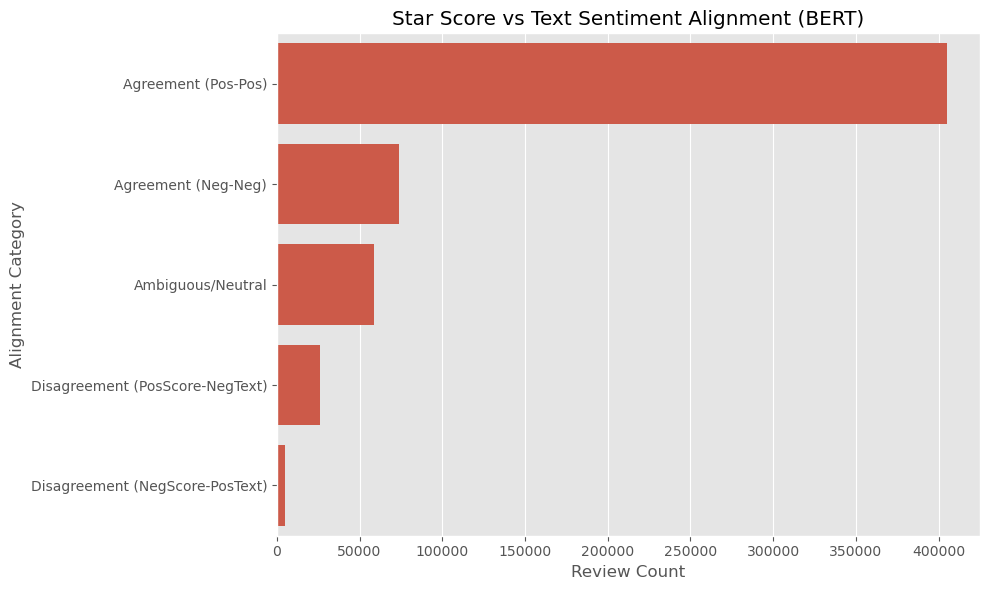

Examples of Positive Score but Negative Text:
        Score  compound  \
Id                        
15403       5 -0.189278   
513699      4 -0.084081   
180744      5 -0.276782   
559049      5 -0.058533   
521670      4 -0.212922   

                                                                                                                                                                                                                                                                                                               Text  
Id                                                                                                                                                                                                                                                                                                                   
15403   I eat brown rice at least 4 times a week. This product was definitely an excellent buy for my needs. However there are two things you sh

In [11]:
# Alignment counts
counts = df['Alignment_BERT'].value_counts()
print(counts)
print((counts / counts.sum() * 100).round(2))

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Alignment_BERT', order=counts.index)
plt.title('Star Score vs Text Sentiment Alignment (BERT)')
plt.xlabel('Review Count')
plt.ylabel('Alignment Category')
plt.tight_layout()
plt.show()

# High-score but negative-text examples
neg_examples = df[df['Alignment_BERT'] == 'Disagreement (PosScore-NegText)']
print("Examples of Positive Score but Negative Text:")
print(neg_examples[['Score', 'compound', 'Text']].sample(min(5, len(neg_examples)), random_state=42))

# Low-score but positive-text examples
pos_examples = df[df['Alignment_BERT'] == 'Disagreement (NegScore-PosText)']
print("Examples of Negative Score but Positive Text:")
print(pos_examples[['Score', 'compound', 'Text']].sample(min(5, len(pos_examples)), random_state=42))

# Save results
output_file = 'Reviews_with_BERT_Alignment.csv'
df[['Score', 'Text', 'neg', 'neu', 'pos', 'compound', 'Alignment_BERT']].to_csv(output_file)
print(f"Results saved to {output_file}")

### 💾 **Output**

- Saves the enhanced dataset (with sentiment and alignment) to a CSV file.
- Prints total runtime for the entire script.

In [12]:
# Timing
end_time = time.time()
print(f"--- Script End ---\nElapsed time: {end_time - start_time:.2f} seconds")

--- Script End ---
Elapsed time: 93265.93 seconds
